In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt

import imageio


In [2]:
def load_video(path: str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = tf.image.rgb_to_grayscale(frame)
        cropped_frame = gray_frame[190:236, 80:220, :]
        frames.append(cropped_frame)

    cap.release()
    frames_tensor = tf.convert_to_tensor(frames, dtype=tf.float32)
    mean_value = tf.reduce_mean(frames_tensor)
    std_dev = tf.math.reduce_std(frames_tensor)
    normalized_frames = (frames_tensor - mean_value) / std_dev

    return normalized_frames


In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!1234567890 "]

In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', ' '] (size =41)


In [5]:
char_to_num(vocab).numpy()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40])

In [6]:
num_to_char(1).numpy().decode('utf-8')

'a'

In [7]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [8]:
lt=load_alignments("/content/drive/MyDrive/lipnet/data/align/bbaf2n.align")

In [9]:
arr=[num_to_char(num).numpy().decode('utf-8') for num in lt]

In [10]:
print(arr)

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']


In [11]:
def load_data(path_tensor):
    path = path_tensor.numpy().decode('utf-8')

    file_name = os.path.splitext(os.path.basename(path))[0]


    base_dir = '/content/drive/MyDrive/lipnet/data'
    video_path = os.path.join(base_dir, 'video', f'{file_name}.mpg')
    alignment_path = os.path.join(base_dir, 'align', f'{file_name}.align')

    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file not found: {video_path}")
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Alignment file not found: {alignment_path}")

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [12]:
# this is a mappable function which inputs load function and path which eventually creating a dataset which include both frame list and alignment data
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [13]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/lipnet/data/video/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [14]:
frames, alignments = data.as_numpy_iterator().next()

In [15]:
arr = [num_to_char(alignment).numpy().tolist() for alignment in alignments]
print(arr)

[[b'l', b'a', b'y', b' ', b'g', b'r', b'e', b'e', b'n', b' ', b'b', b'y', b' ', b's', b' ', b'e', b'i', b'g', b'h', b't', b' ', b'p', b'l', b'e', b'a', b's', b'e', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b''], [b'p', b'l', b'a', b'c', b'e', b' ', b's', b'p', b' ', b'b', b'l', b'u', b'e', b' ', b'a', b't', b' ', b'i', b' ', b's', b'i', b'x', b' ', b'p', b'l', b'e', b'a', b's', b'e', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'']]


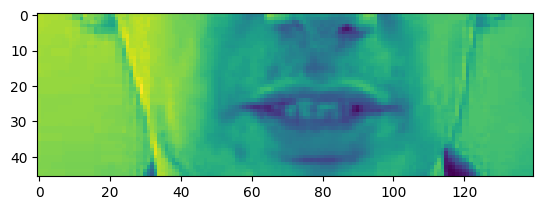

In [16]:
val = train.as_numpy_iterator().next()
plt.imshow(val[0][0][50])

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [18]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [20]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [22]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [1]:
model.fit(train, validation_data=test, epochs=20, callbacks=checkpoint_callback)

NameError: name 'model' is not defined